GENERATIVE MODEL DEMONSTRATION
Objective: Train f₁: Z → Y where Z ~ N(0,I) and Y ~ Uniform[0,1]²
Method: Fully connected neural network with explicit SGD updates
Loss: Approximate Wasserstein distance between generated and target distributions

Training Generative Model: Z ~ N(0,I) -> Y ~ Uniform[0,1]^2
Architecture: 2 -> 128 -> 128 -> 128 -> 2 (with ReLU + Sigmoid)
Learning rate: 0.001, Batch size: 512
------------------------------------------------------------
Epoch 1000/5000, Loss: 0.009322
Epoch 2000/5000, Loss: 0.008050
Epoch 3000/5000, Loss: 0.002110
Epoch 4000/5000, Loss: 0.004325
Epoch 5000/5000, Loss: 0.005394

Training completed!


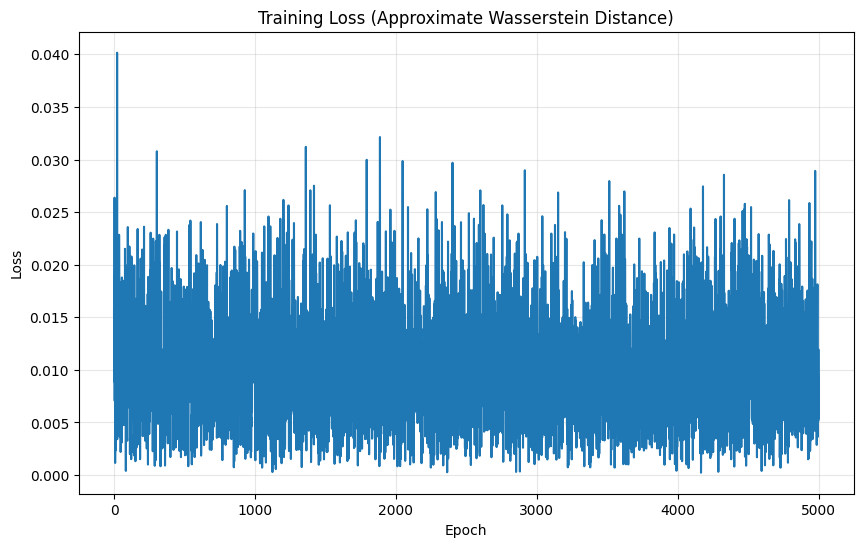

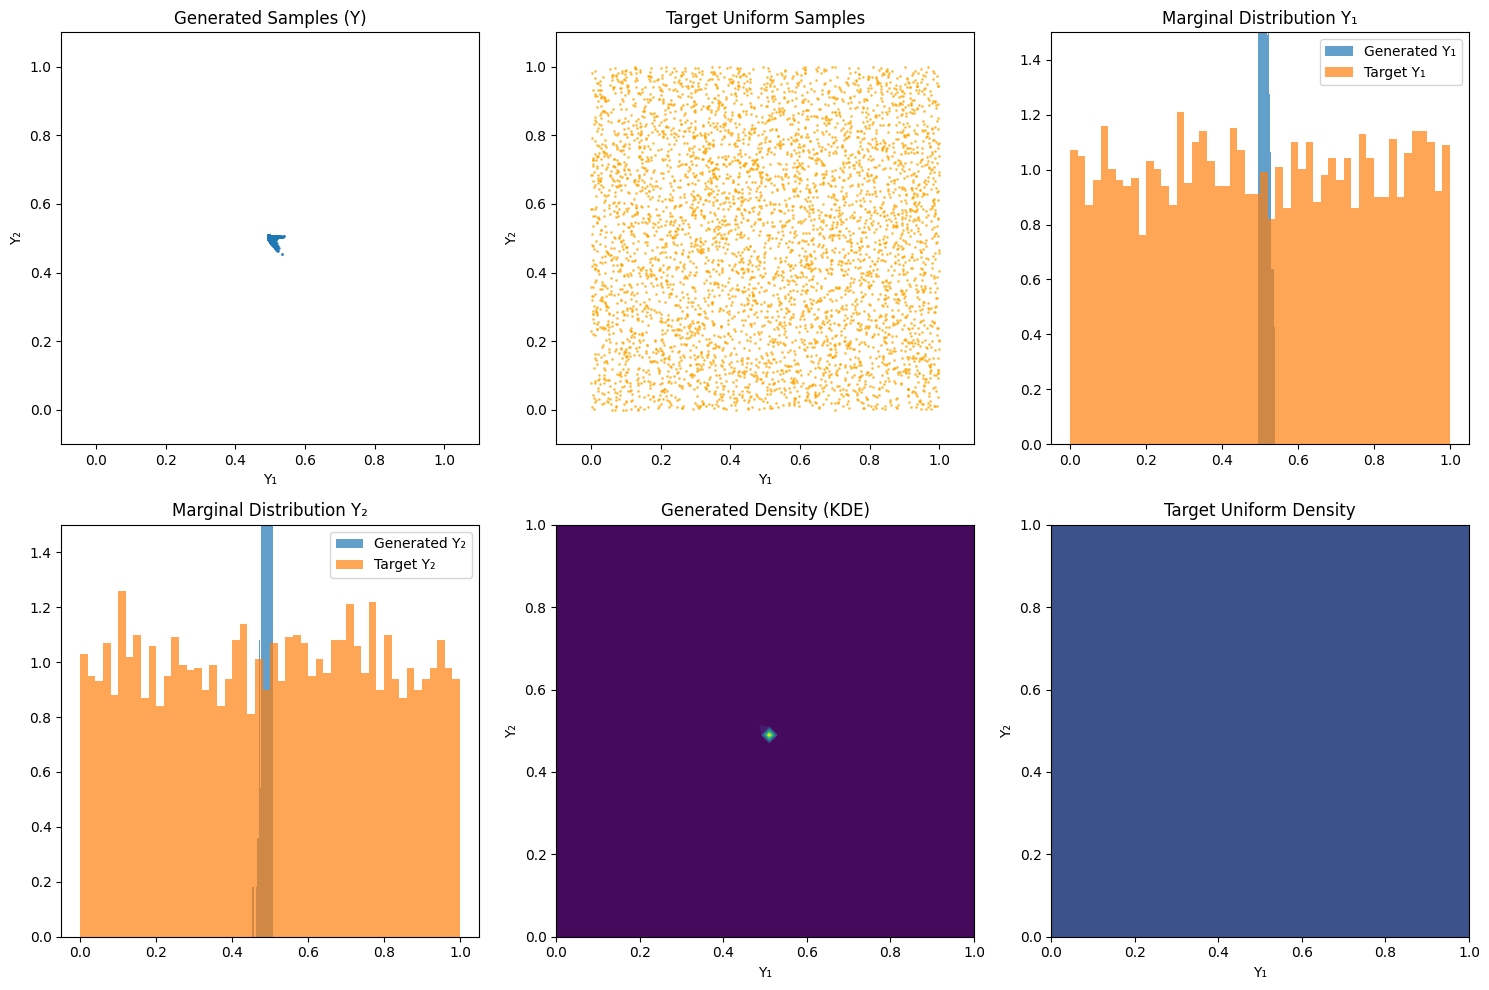


Evaluation Results:
Generated samples mean: (0.4999, 0.5007)
Generated samples std:  (0.0063, 0.0059)
Target uniform mean: (0.5000, 0.5000)
Target uniform std:  (0.2887, 0.2887)
All generated samples in [0,1]²: True
Proportion in range: 1.0000

PRINCIPLE OF GENERATIVE MODELS

    This implementation demonstrates the core principle of generative models:
    
    1. TRANSFORMATION: We learn a mapping f₁: Z → Y that transforms simple noise
       distribution Z ~ N(0,I) into complex target distribution Y ~ Uniform[0,1]²
    
    2. NEURAL PARAMETERIZATION: The transformation f₁ is parameterized by a neural
       network with learnable weights θ, so f₁(z; θ) ≈ y_target
    
    3. DISTRIBUTION MATCHING: We minimize a distance metric (Wasserstein distance)
       between the generated distribution f₁(Z; θ) and target distribution Y
    
    4. SGD OPTIMIZATION: Parameters θ are updated using explicit stochastic gradient
       descent to minimize the distribution distance
    
    5. EMPI

In [1]:
#2.1

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn

class Generator(nn.Module):
    """
    Fully connected neural network that transforms 2D Gaussian noise Z ~ N(0,I)
    into 2D uniform distribution Y over unit square [0,1]^2
    """
    def __init__(self, hidden_dim=128):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Sigmoid()  # Maps to [0,1] range for uniform distribution
        )

    def forward(self, z):
        return self.network(z)

def sample_target_distribution(n_samples):
    """Sample from target uniform distribution over [0,1]^2"""
    return np.random.uniform(0, 1, size=(n_samples, 2))

def wasserstein_distance_approx(real_samples, fake_samples, n_critics=1000):
    """
    Approximate Wasserstein distance using random linear functionals
    This provides a differentiable loss for training the generator
    """
    # Generate random directions (critics)
    critics = torch.randn(n_critics, 2)
    critics = critics / torch.norm(critics, dim=1, keepdim=True)

    # Project samples onto critics
    real_proj = torch.matmul(real_samples, critics.t())
    fake_proj = torch.matmul(fake_samples, critics.t())

    # Compute mean projections
    real_mean = torch.mean(real_proj, dim=0)
    fake_mean = torch.mean(fake_proj, dim=0)

    # Wasserstein distance approximation
    return torch.mean(torch.abs(real_mean - fake_mean))

def explicit_sgd_step(model, loss, learning_rate):
    """
    Explicit SGD update step - manually computing and applying gradients
    """
    # Compute gradients
    loss.backward()

    # Manual SGD update for each parameter
    with torch.no_grad():
        for param in model.parameters():
            if param.grad is not None:
                # SGD update: param = param - learning_rate * gradient
                param.data -= learning_rate * param.grad
                # Clear gradients for next iteration
                param.grad.zero_()

def train_generator():
    """
    Train generator using explicit SGD iterations
    """
    # Model setup
    generator = Generator(hidden_dim=128)
    learning_rate = 0.001
    n_epochs = 5000
    batch_size = 512

    # Training history
    losses = []

    print("Training Generative Model: Z ~ N(0,I) -> Y ~ Uniform[0,1]^2")
    print(f"Architecture: 2 -> 128 -> 128 -> 128 -> 2 (with ReLU + Sigmoid)")
    print(f"Learning rate: {learning_rate}, Batch size: {batch_size}")
    print("-" * 60)

    for epoch in range(n_epochs):
        # Sample noise from standard normal
        z = torch.randn(batch_size, 2)

        # Generate samples
        y_fake = generator(z)

        # Sample from target uniform distribution
        y_real = torch.from_numpy(sample_target_distribution(batch_size)).float()

        # Compute loss (approximate Wasserstein distance)
        loss = wasserstein_distance_approx(y_real, y_fake, n_critics=200)

        # Explicit SGD step
        explicit_sgd_step(generator, loss, learning_rate)

        # Record loss
        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")

    return generator, losses

def evaluate_model(generator, n_samples=5000):
    """
    Evaluate the trained generator by comparing generated samples with target distribution
    """
    # Generate samples
    with torch.no_grad():
        z = torch.randn(n_samples, 2)
        generated_samples = generator(z).numpy()

    # Target samples
    target_samples = sample_target_distribution(n_samples)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot generated samples
    axes[0, 0].scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=1)
    axes[0, 0].set_title('Generated Samples (Y)')
    axes[0, 0].set_xlabel('Y₁')
    axes[0, 0].set_ylabel('Y₂')
    axes[0, 0].set_xlim(-0.1, 1.1)
    axes[0, 0].set_ylim(-0.1, 1.1)

    # Plot target samples
    axes[0, 1].scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.6, s=1, color='orange')
    axes[0, 1].set_title('Target Uniform Samples')
    axes[0, 1].set_xlabel('Y₁')
    axes[0, 1].set_ylabel('Y₂')
    axes[0, 1].set_xlim(-0.1, 1.1)
    axes[0, 1].set_ylim(-0.1, 1.1)

    # Plot marginal distributions
    axes[0, 2].hist(generated_samples[:, 0], bins=50, alpha=0.7, density=True, label='Generated Y₁')
    axes[0, 2].hist(target_samples[:, 0], bins=50, alpha=0.7, density=True, label='Target Y₁')
    axes[0, 2].set_title('Marginal Distribution Y₁')
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1.5)

    axes[1, 0].hist(generated_samples[:, 1], bins=50, alpha=0.7, density=True, label='Generated Y₂')
    axes[1, 0].hist(target_samples[:, 1], bins=50, alpha=0.7, density=True, label='Target Y₂')
    axes[1, 0].set_title('Marginal Distribution Y₂')
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1.5)

    # 2D density plots
    try:
        # Generated samples density
        kde_gen = gaussian_kde(generated_samples.T)
        x_grid = np.linspace(0, 1, 50)
        y_grid = np.linspace(0, 1, 50)
        X, Y = np.meshgrid(x_grid, y_grid)
        positions = np.vstack([X.ravel(), Y.ravel()])
        density_gen = kde_gen(positions).reshape(X.shape)

        im1 = axes[1, 1].contourf(X, Y, density_gen, levels=20, cmap='viridis')
        axes[1, 1].set_title('Generated Density (KDE)')
        axes[1, 1].set_xlabel('Y₁')
        axes[1, 1].set_ylabel('Y₂')

        # Target uniform density (should be constant = 1)
        uniform_density = np.ones_like(X)
        im2 = axes[1, 2].contourf(X, Y, uniform_density, levels=20, cmap='viridis')
        axes[1, 2].set_title('Target Uniform Density')
        axes[1, 2].set_xlabel('Y₁')
        axes[1, 2].set_ylabel('Y₂')

    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'KDE Error: {str(e)}', ha='center', va='center')
        axes[1, 2].text(0.5, 0.5, 'Target: Uniform density = 1', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    # Compute statistics
    print("\nEvaluation Results:")
    print(f"Generated samples mean: ({generated_samples[:, 0].mean():.4f}, {generated_samples[:, 1].mean():.4f})")
    print(f"Generated samples std:  ({generated_samples[:, 0].std():.4f}, {generated_samples[:, 1].std():.4f})")
    print(f"Target uniform mean: (0.5000, 0.5000)")
    print(f"Target uniform std:  (0.2887, 0.2887)")  # 1/√12 ≈ 0.2887

    # Check if samples are in [0,1] range
    in_range = np.all((generated_samples >= 0) & (generated_samples <= 1))
    print(f"All generated samples in [0,1]²: {in_range}")
    print(f"Proportion in range: {np.mean((generated_samples >= 0).all(axis=1) & (generated_samples <= 1).all(axis=1)):.4f}")

def plot_training_curve(losses):
    """Plot the training loss curve"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss (Approximate Wasserstein Distance)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

def demonstrate_transformation():
    """
    Demonstrate the transformation from Gaussian noise to uniform distribution
    """
    print("="*80)
    print("GENERATIVE MODEL DEMONSTRATION")
    print("="*80)
    print("Objective: Train f₁: Z → Y where Z ~ N(0,I) and Y ~ Uniform[0,1]²")
    print("Method: Fully connected neural network with explicit SGD updates")
    print("Loss: Approximate Wasserstein distance between generated and target distributions")
    print()

    # Train the model
    generator, losses = train_generator()

    print("\nTraining completed!")

    # Plot training curve
    plot_training_curve(losses)

    # Evaluate the model
    evaluate_model(generator)

    return generator

# Run the demonstration
if __name__ == "__main__":
    trained_generator = demonstrate_transformation()

    # Show the principle of generative modeling
    print("\n" + "="*80)
    print("PRINCIPLE OF GENERATIVE MODELS")
    print("="*80)
    print("""
    This implementation demonstrates the core principle of generative models:

    1. TRANSFORMATION: We learn a mapping f₁: Z → Y that transforms simple noise
       distribution Z ~ N(0,I) into complex target distribution Y ~ Uniform[0,1]²

    2. NEURAL PARAMETERIZATION: The transformation f₁ is parameterized by a neural
       network with learnable weights θ, so f₁(z; θ) ≈ y_target

    3. DISTRIBUTION MATCHING: We minimize a distance metric (Wasserstein distance)
       between the generated distribution f₁(Z; θ) and target distribution Y

    4. SGD OPTIMIZATION: Parameters θ are updated using explicit stochastic gradient
       descent to minimize the distribution distance

    5. EMPIRICAL LEARNING: The method works with only empirical samples from the
       target distribution (no analytical form required) - this would extend to
       cat images or any other complex data distribution

    Key insight: Once trained, we can generate unlimited samples from the target
    distribution by sampling z ~ N(0,I) and computing y = f₁(z; θ)
    """)

BIDIRECTIONAL GENERATIVE MODEL DEMONSTRATION
Objective: Train f₁: Z → Y and f₂: Y → Z
f₁: Z ~ N(0,I) → Y ~ Uniform[0,1]²
f₂: Y ~ Uniform[0,1]² → Z ~ N(0,I)
Method: Two fully connected neural networks with explicit SGD updates

Training Generative Model: Z ~ N(0,I) -> Y ~ Uniform[0,1]^2
Architecture: 2 -> 128 -> 128 -> 128 -> 2 (with ReLU + Sigmoid)
Learning rate: 0.001, Batch size: 512
------------------------------------------------------------
Epoch 1000/5000, Loss: 0.003273
Epoch 2000/5000, Loss: 0.003884
Epoch 3000/5000, Loss: 0.005041
Epoch 4000/5000, Loss: 0.007807
Epoch 5000/5000, Loss: 0.009248

Forward model f₁ training completed!

Training Inverse Generative Model: Y ~ Uniform[0,1]^2 -> Z ~ N(0,I)
Architecture: 2 -> 128 -> 128 -> 128 -> 2 (with ReLU)
Learning rate: 0.001, Batch size: 512
------------------------------------------------------------
Epoch 1000/5000, Loss: 0.026984
Epoch 2000/5000, Loss: 0.039323
Epoch 3000/5000, Loss: 0.054622
Epoch 4000/5000, Loss: 0.023212
Ep

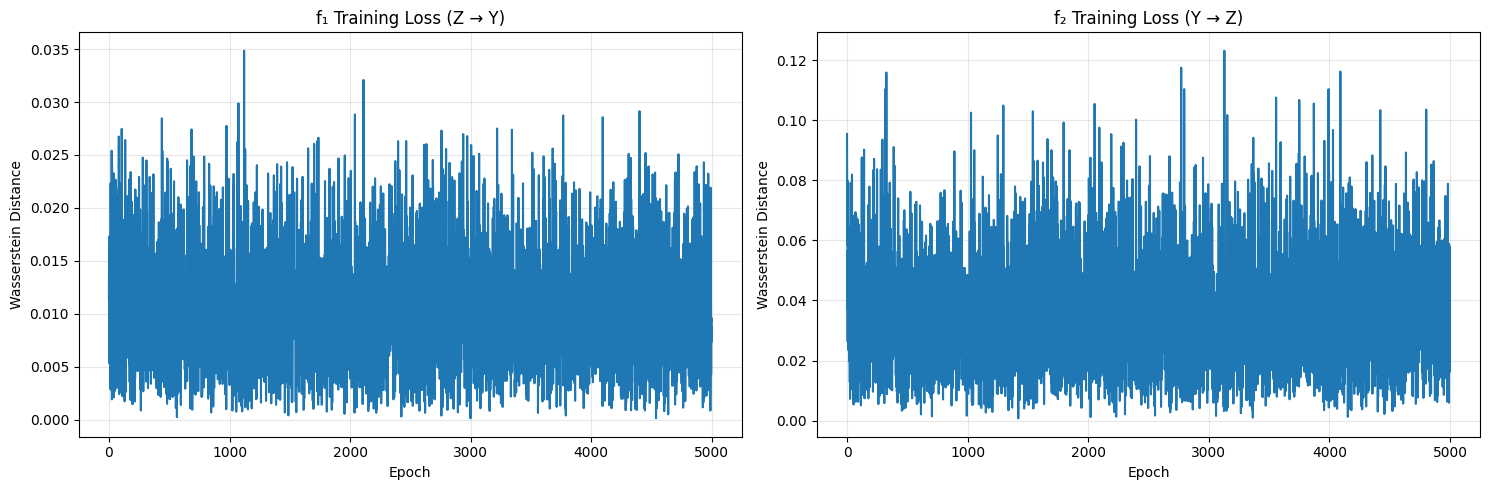


EVALUATING FORWARD MODEL f₁


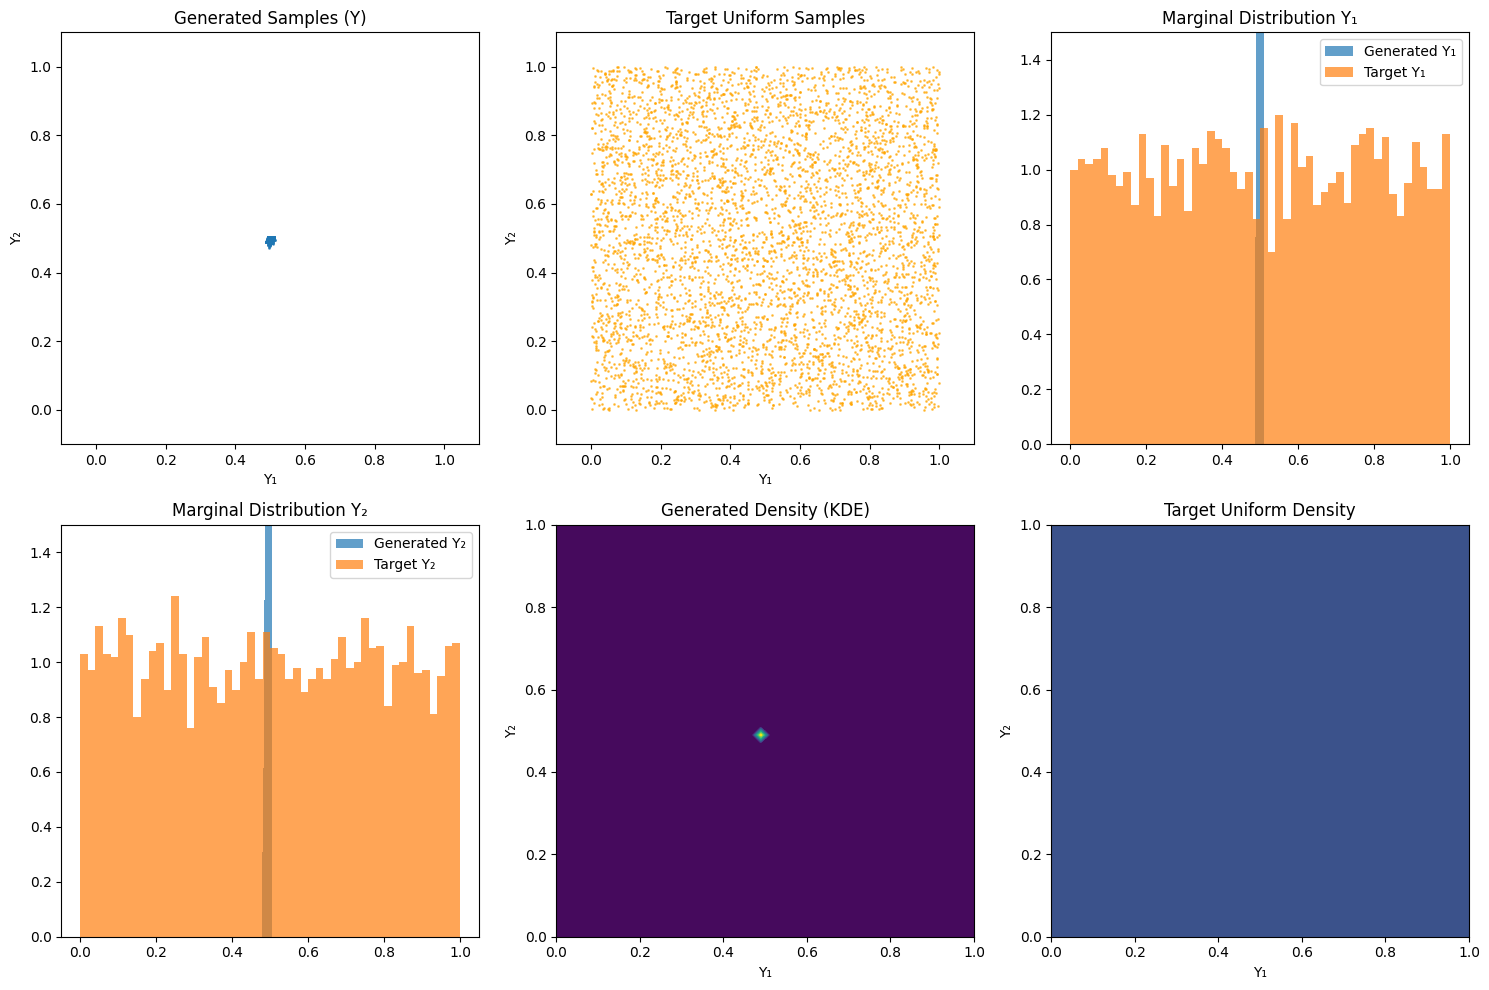


Evaluation Results:
Generated samples mean: (0.4996, 0.5002)
Generated samples std:  (0.0043, 0.0039)
Target uniform mean: (0.5000, 0.5000)
Target uniform std:  (0.2887, 0.2887)
All generated samples in [0,1]²: True
Proportion in range: 1.0000

EVALUATING INVERSE MODEL f₂


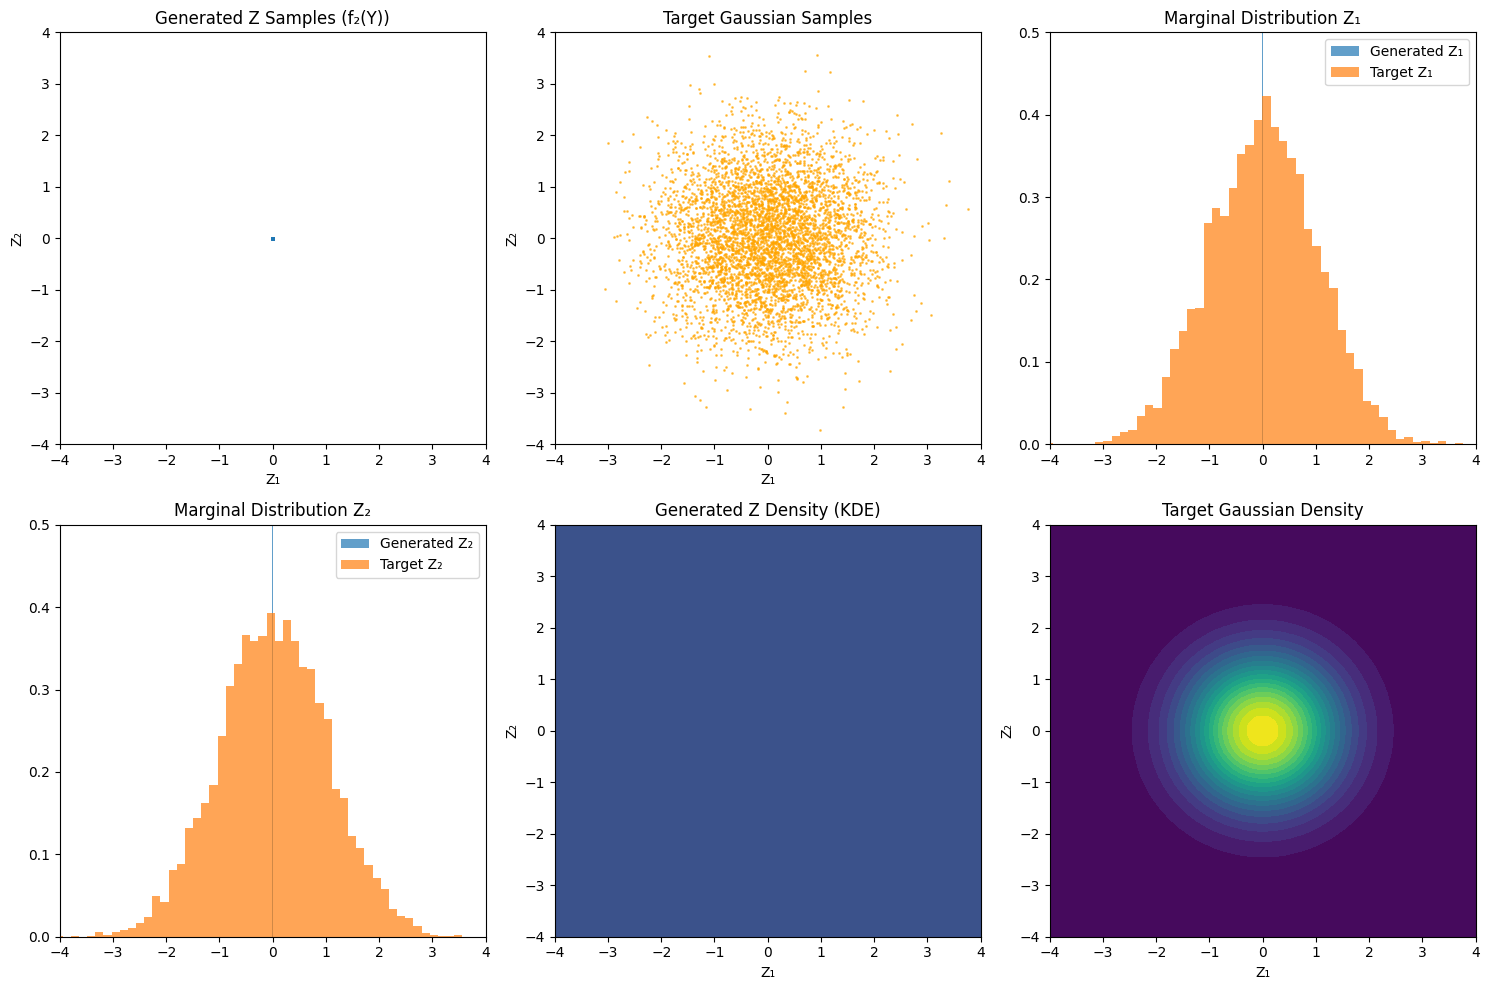


Evaluation Results (Inverse Model):
Generated Z samples mean: (-0.0013, -0.0017)
Generated Z samples std:  (0.0093, 0.0039)
Target Gaussian mean: (0.0000, 0.0000)
Target Gaussian std:  (1.0000, 1.0000)

TESTING INVERTIBILITY (f₂(f₁(Z)) ≈ Z and f₁(f₂(Y)) ≈ Y)

Testing Z -> Y -> Z reconstruction:
Mean L2 reconstruction error (Z -> Y -> Z): 1.261754


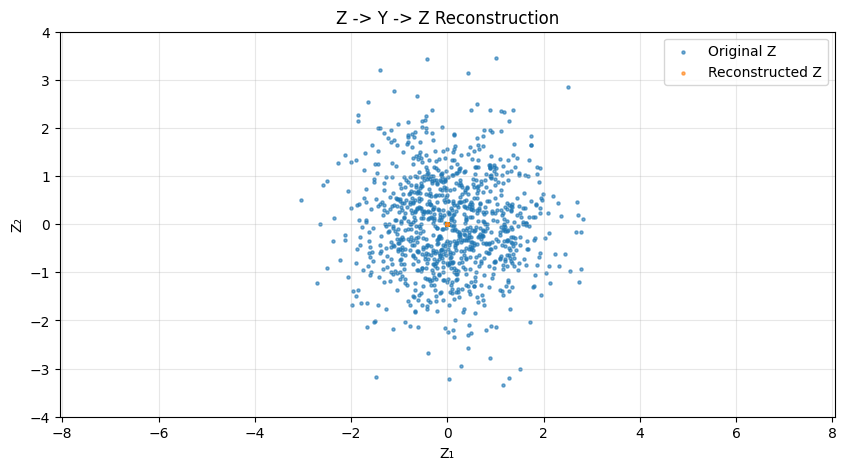


Testing Y -> Z -> Y reconstruction:
Mean L2 reconstruction error (Y -> Z -> Y): 0.380408


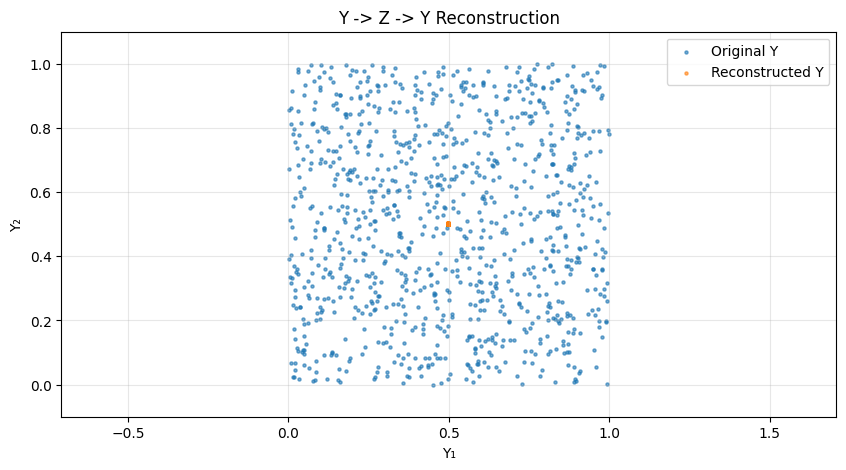


PRINCIPLE OF BIDIRECTIONAL GENERATIVE MODELS

    This implementation demonstrates bidirectional generative modeling:

    1. FORWARD TRANSFORMATION f₁: Learn mapping Z ~ N(0,I) → Y ~ Uniform[0,1]²
       - Neural network with sigmoid output activation
       - Maps unbounded Gaussian to bounded uniform distribution

    2. INVERSE TRANSFORMATION f₂: Learn mapping Y ~ Uniform[0,1]² → Z ~ N(0,I)
       - Neural network with no output activation (unbounded output)
       - Maps bounded uniform to unbounded Gaussian distribution

    3. EXPLICIT SGD IMPLEMENTATION: Both networks trained using manual gradient
       computation and parameter updates: θ ← θ - η∇L(θ)

    4. DISTRIBUTION MATCHING: Wasserstein distance minimization between generated
       and target empirical distributions for both directions

    5. INVERTIBILITY TESTING: Verify that f₂(f₁(z)) ≈ z and f₁(f₂(y)) ≈ y
       - Perfect invertibility would mean the transformations are bijective
       - Reconstruction error mea

In [12]:
#2.2
def demonstrate_transformation():
    """
    Demonstrate the transformation from Gaussian noise to uniform distribution
    and the inverse transformation
    """
    print("="*80)
    print("BIDIRECTIONAL GENERATIVE MODEL DEMONSTRATION")
    print("="*80)
    print("Objective: Train f₁: Z → Y and f₂: Y → Z")
    print("f₁: Z ~ N(0,I) → Y ~ Uniform[0,1]²")
    print("f₂: Y ~ Uniform[0,1]² → Z ~ N(0,I)")
    print("Method: Two fully connected neural networks with explicit SGD updates")
    print()

    # Train the forward model f₁
    generator, losses_f1 = train_generator()
    print("\nForward model f₁ training completed!")

    # Train the inverse model f₂
    inverse_generator, losses_f2 = train_inverse_generator()
    print("\nInverse model f₂ training completed!")

    # Plot training curves for both models
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(losses_f1)
    ax1.set_title('f₁ Training Loss (Z → Y)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.grid(True, alpha=0.3)

    ax2.plot(losses_f2)
    ax2.set_title('f₂ Training Loss (Y → Z)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Wasserstein Distance')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Evaluate both models
    print("\n" + "="*60)
    print("EVALUATING FORWARD MODEL f₁")
    print("="*60)
    evaluate_model(generator)

    print("\n" + "="*60)
    print("EVALUATING INVERSE MODEL f₂")
    print("="*60)
    evaluate_inverse_model(inverse_generator)

    # Test invertibility
    test_invertibility(generator, inverse_generator)

    return generator, inverse_generator

# Run the demonstration
if __name__ == "__main__":
    generator_f1, inverse_generator_f2 = demonstrate_transformation()

    # Show the principle of bidirectional generative modeling
    print("\n" + "="*80)
    print("PRINCIPLE OF BIDIRECTIONAL GENERATIVE MODELS")
    print("="*80)
    print("""
    This implementation demonstrates bidirectional generative modeling:

    1. FORWARD TRANSFORMATION f₁: Learn mapping Z ~ N(0,I) → Y ~ Uniform[0,1]²
       - Neural network with sigmoid output activation
       - Maps unbounded Gaussian to bounded uniform distribution

    2. INVERSE TRANSFORMATION f₂: Learn mapping Y ~ Uniform[0,1]² → Z ~ N(0,I)
       - Neural network with no output activation (unbounded output)
       - Maps bounded uniform to unbounded Gaussian distribution

    3. EXPLICIT SGD IMPLEMENTATION: Both networks trained using manual gradient
       computation and parameter updates: θ ← θ - η∇L(θ)

    4. DISTRIBUTION MATCHING: Wasserstein distance minimization between generated
       and target empirical distributions for both directions

    5. INVERTIBILITY TESTING: Verify that f₂(f₁(z)) ≈ z and f₁(f₂(y)) ≈ y
       - Perfect invertibility would mean the transformations are bijective
       - Reconstruction error measures quality of inverse relationship

    6. ARCHITECTURAL DIFFERENCES:
       - f₁: Uses sigmoid activation to map to [0,1] (uniform support)
       - f₂: No output activation to map to ℝ² (Gaussian support)

    Applications:
    - Normalizing flows (invertible neural networks)
    - Variational autoencoders (encoder/decoder pair)
    - Domain transfer (e.g., style transfer between image domains)
    - Data augmentation through noise injection and recovery

    The same principle extends to complex high-dimensional data like images,
    where f₁ could generate images from noise and f₂ could encode images back
    to latent space (like in VAEs or GANs with encoders).
    """)

In [11]:
def demonstrate_transformation():
    """
    Demonstrate the transformation from Gaussian noise to uniform distribution
    and the inverse transformation
    """
    print("="*80)
    print("BIDIRECTIONAL GENERATIVE MODEL DEMONSTRATION")
    print("="*80)
    print("Objective: Train f₁: Z → Y and f₂: Y → Z")
    print("f₁: Z ~ N(0,I) → Y ~ Uniform[0,1]²")
    print("f₂: Y ~ Uniform[0,1]² → Z ~ N(0,I)")
    print("Method: Two fully connected neural networks with explicit SGD updates")
    print()

    # Train the forward model f₁
    generator, losses_f1 = train_generator()
    print("\nForward model f₁ training completed!")

    # Train the inverse model f₂
    inverse_generator, losses_f2 = train_inverse_generator()
    print("\nInverse model f₂ training completed!")

    # Plot training curves for both models
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(losses_f1)
    ax1.set_title('f₁ Training Loss (Z → Y)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.grid(True, alpha=0.3)

    ax2.plot(losses_f2)
    ax2.set_title('f₂ Training Loss (Y → Z)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Wasserstein Distance')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Evaluate both models
    print("\n" + "="*60)
    print("EVALUATING FORWARD MODEL f₁")
    print("="*60)
    evaluate_model(generator)

    print("\n" + "="*60)
    print("EVALUATING INVERSE MODEL f₂")
    print("="*60)
    evaluate_inverse_model(inverse_generator)

    # Test invertibility
    test_invertibility(generator, inverse_generator)

    return generator, inverse_generator

Choose demonstration:
1. Basic bidirectional model (f₁ and f₂)
2. Regularization effects analysis
3. Both demonstrations
REGULARIZATION EFFECTS DEMONSTRATION
Training multiple models with different regularization strengths...
This will show how L1 and L2 regularization affect:
1. Weight distributions and sparsity
2. Model performance and generalization
3. Training dynamics


Training: No Regularization

Training Generator with No Regularization
L1 weight: 0.0, L2 weight: 0.0
Learning rate: 0.001, Batch size: 512
------------------------------------------------------------
Epoch 1000/5000, Total Loss: 0.008897, Wasserstein: 0.008897, Reg: 0.000000
Epoch 2000/5000, Total Loss: 0.002660, Wasserstein: 0.002660, Reg: 0.000000
Epoch 3000/5000, Total Loss: 0.019188, Wasserstein: 0.019188, Reg: 0.000000
Epoch 4000/5000, Total Loss: 0.018795, Wasserstein: 0.018795, Reg: 0.000000
Epoch 5000/5000, Total Loss: 0.014293, Wasserstein: 0.014293, Reg: 0.000000

Training: L1 (λ=0.001)

Training Generat

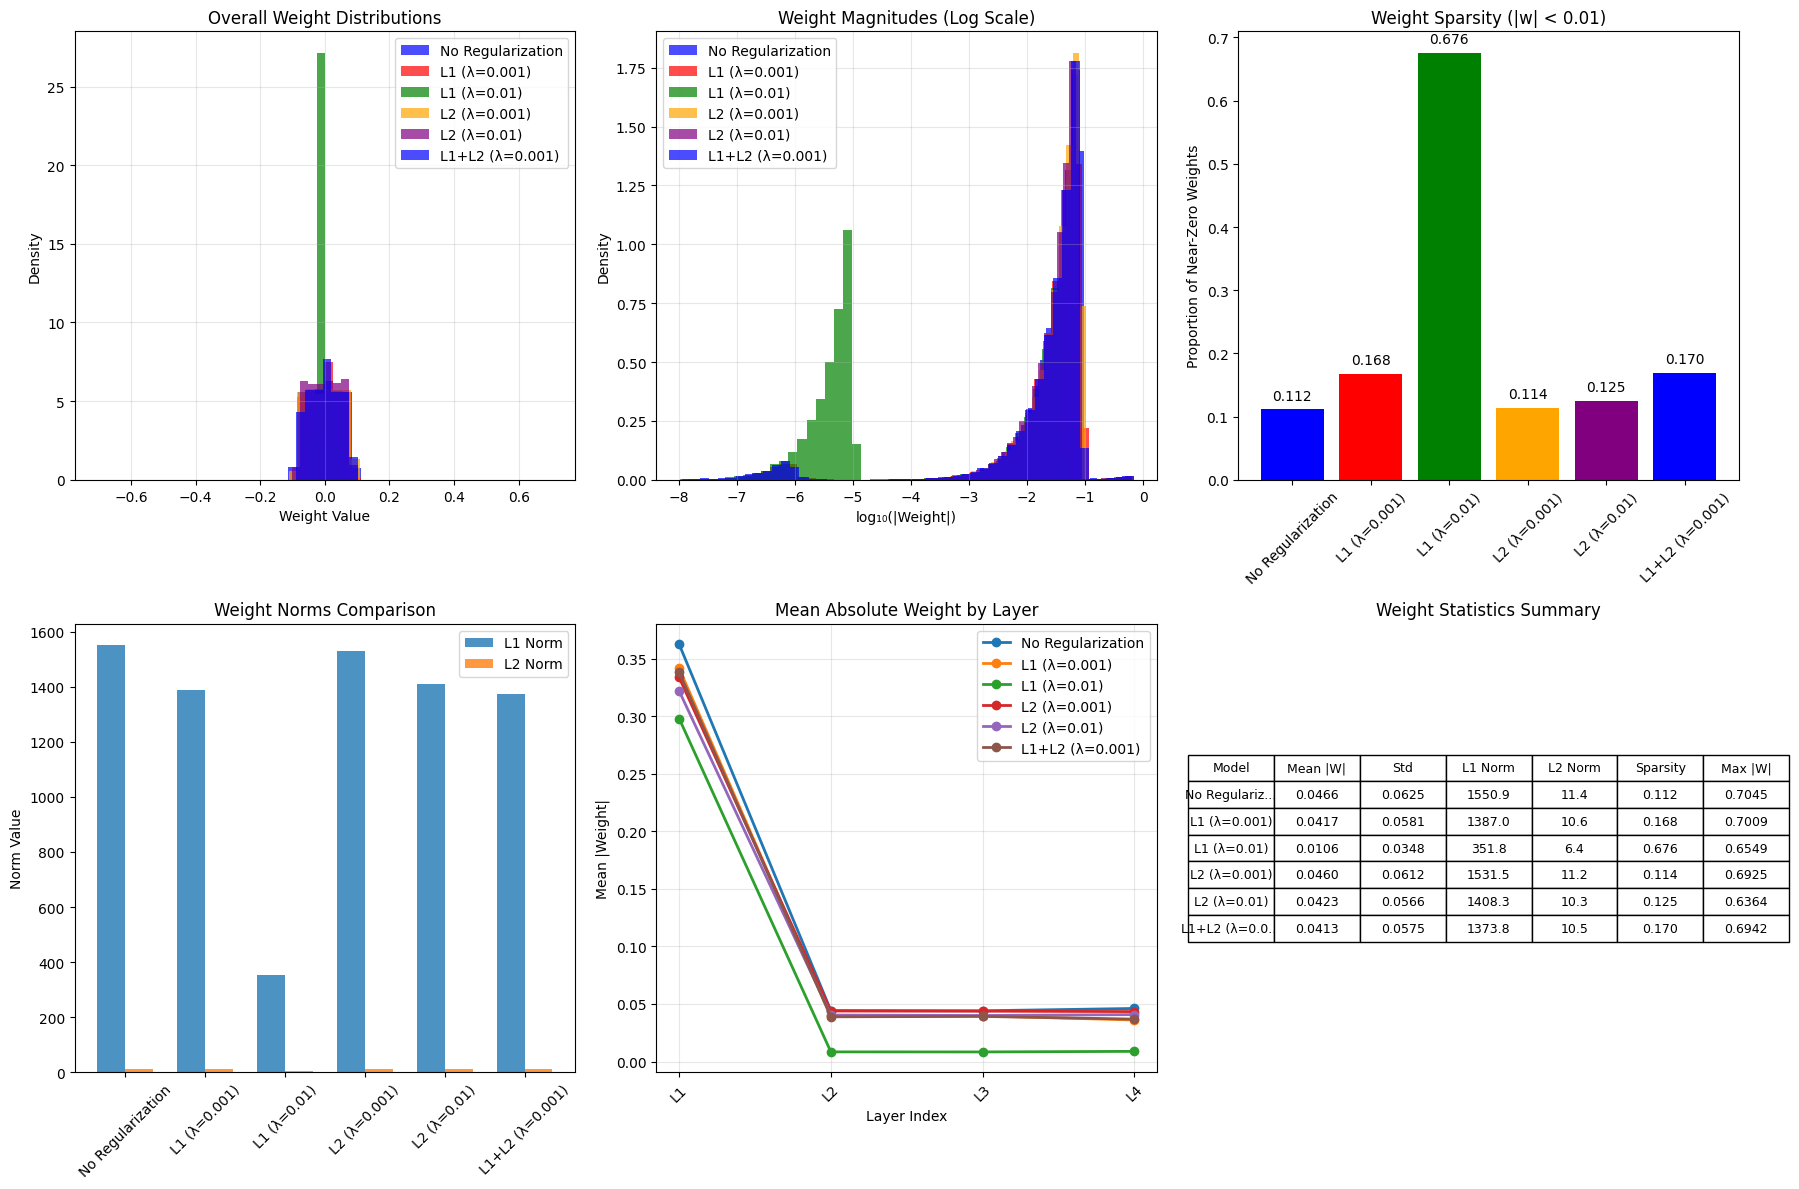


Detailed Weight Statistics:
--------------------------------------------------------------------------------

No Regularization:
  Mean |Weight|: 0.046601
  Std Weight:    0.062483
  L1 Norm:       1550.88
  L2 Norm:       11.40
  Sparsity:      0.1119 (11.2% near-zero)
  Max |Weight|:  0.704522

L1 (λ=0.001):
  Mean |Weight|: 0.041676
  Std Weight:    0.058124
  L1 Norm:       1386.97
  L2 Norm:       10.60
  Sparsity:      0.1677 (16.8% near-zero)
  Max |Weight|:  0.700930

L1 (λ=0.01):
  Mean |Weight|: 0.010570
  Std Weight:    0.034815
  L1 Norm:       351.76
  L2 Norm:       6.35
  Sparsity:      0.6759 (67.6% near-zero)
  Max |Weight|:  0.654895

L2 (λ=0.001):
  Mean |Weight|: 0.046018
  Std Weight:    0.061191
  L1 Norm:       1531.50
  L2 Norm:       11.16
  Sparsity:      0.1143 (11.4% near-zero)
  Max |Weight|:  0.692513

L2 (λ=0.01):
  Mean |Weight|: 0.042318
  Std Weight:    0.056563
  L1 Norm:       1408.34
  L2 Norm:       10.32
  Sparsity:      0.1252 (12.5% near-zero)


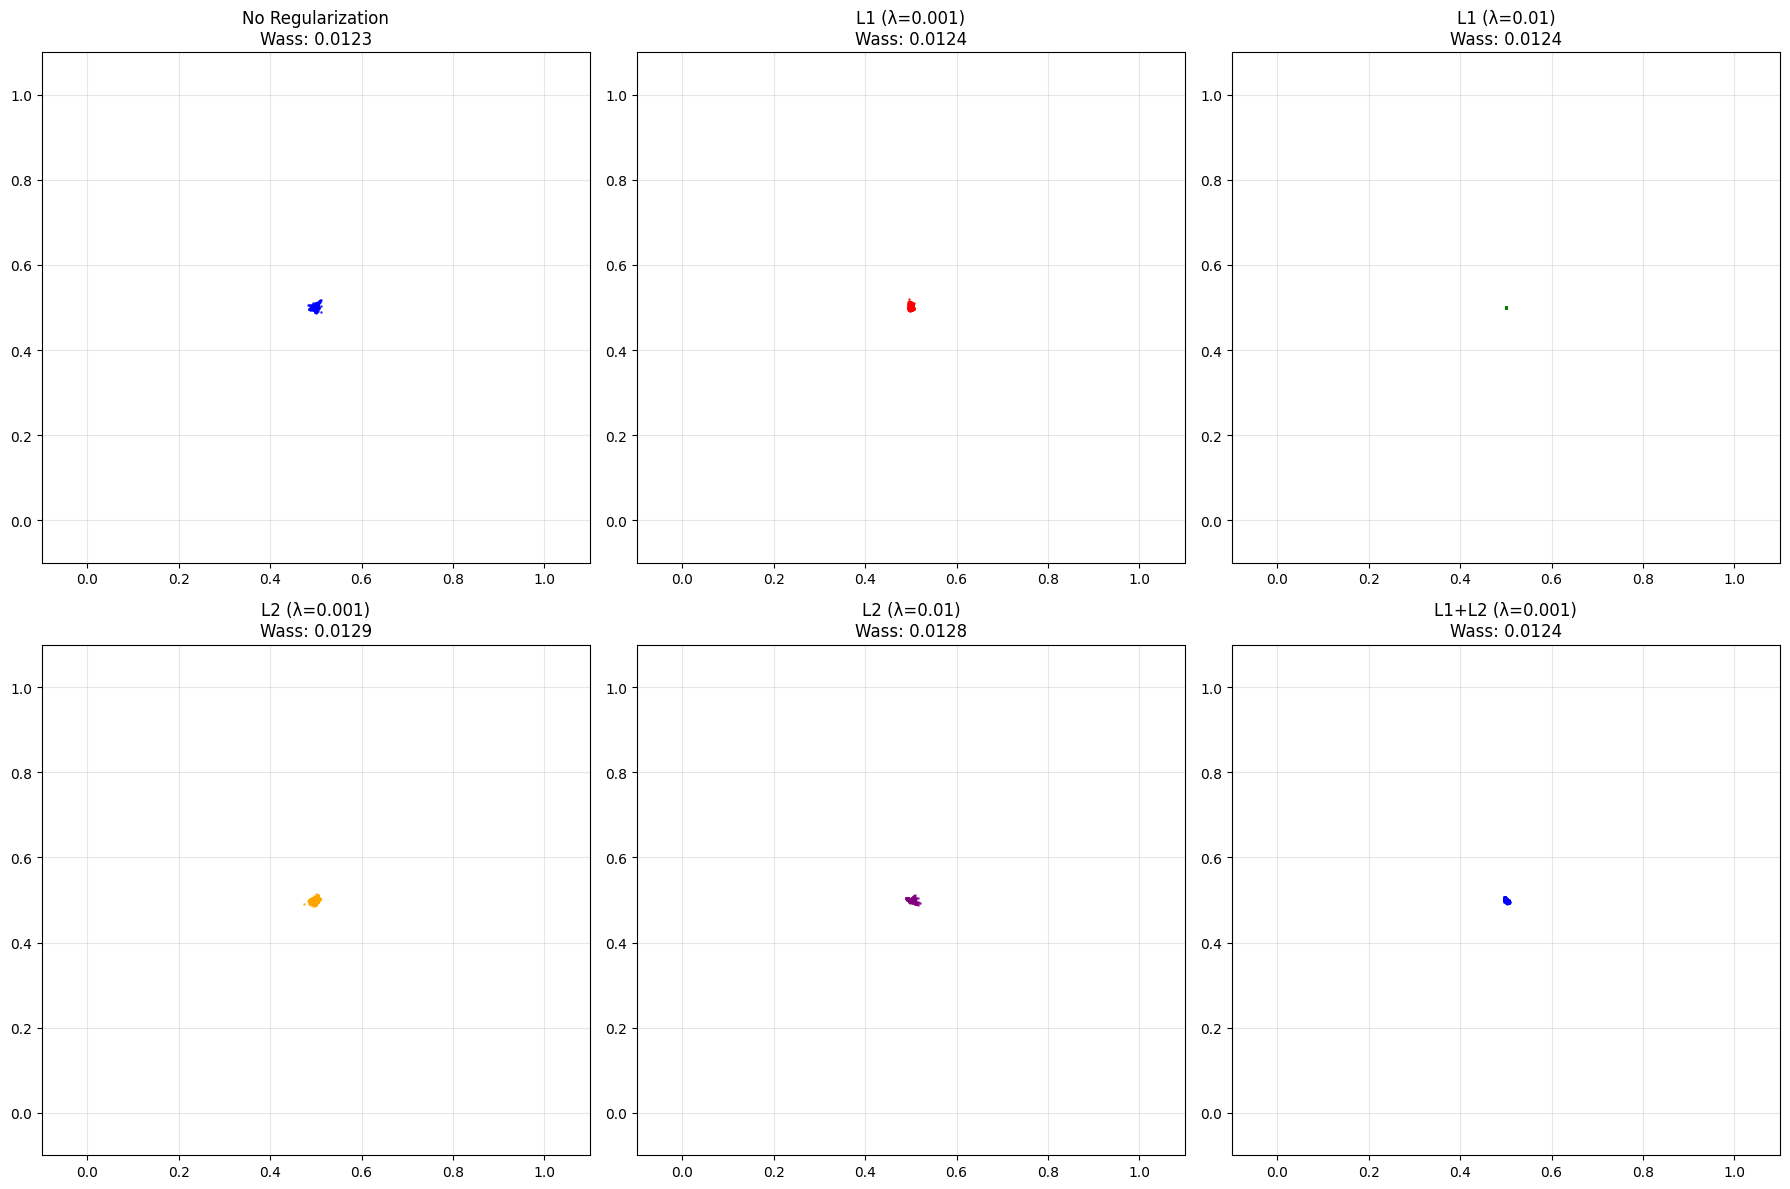

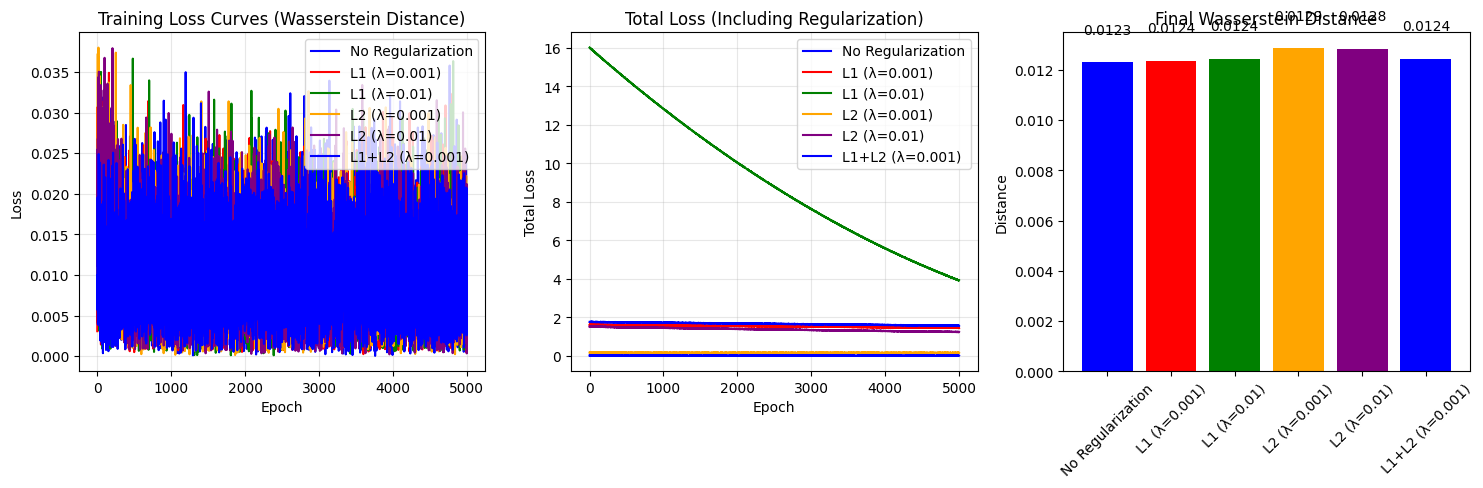


Performance Metrics Comparison:
----------------------------------------------------------------------------------------------------
Model                Wasserstein  Mean Error   Var Error    In Range   KL Div    
----------------------------------------------------------------------------------------------------
No Regularization    0.012309     0.000572     0.117821     1.0000     16.8187   
L1 (λ=0.001)         0.012366     0.000686     0.117823     1.0000     16.8184   
L1 (λ=0.01)          0.012440     0.000052     0.117851     1.0000     16.8181   
L2 (λ=0.001)         0.012851     0.000862     0.117808     1.0000     16.8188   
L2 (λ=0.01)          0.012835     0.000651     0.117822     1.0000     16.8184   
L1+L2 (λ=0.001)      0.012435     0.000250     0.117840     1.0000     16.8207   

DISCUSSION: REGULARIZATION EFFECTS

OBSERVED EFFECTS OF REGULARIZATION:

1. L1 REGULARIZATION (Lasso):
   - Promotes SPARSITY: Many weights become exactly zero or near-zero
   - Acts as auto

TypeError: cannot unpack non-iterable NoneType object

In [16]:
#2.3
def demonstrate_regularization_effects():
    """
    Demonstrate the effects of L1 and L2 regularization on weight distributions and model performance
    """
    print("="*80)
    print("REGULARIZATION EFFECTS DEMONSTRATION")
    print("="*80)
    print("Training multiple models with different regularization strengths...")
    print("This will show how L1 and L2 regularization affect:")
    print("1. Weight distributions and sparsity")
    print("2. Model performance and generalization")
    print("3. Training dynamics")
    print()

    # Define regularization configurations
    regularization_configs = [
        {"l1": 0.0, "l2": 0.0, "name": "No Regularization"},
        {"l1": 0.001, "l2": 0.0, "name": "L1 (λ=0.001)"},
        {"l1": 0.01, "l2": 0.0, "name": "L1 (λ=0.01)"},
        {"l1": 0.0, "l2": 0.001, "name": "L2 (λ=0.001)"},
        {"l1": 0.0, "l2": 0.01, "name": "L2 (λ=0.01)"},
        {"l1": 0.001, "l2": 0.001, "name": "L1+L2 (λ=0.001)"}
    ]

    # Train models with different regularization
    models = {}
    all_losses = {}

    for config in regularization_configs:
        print(f"\n{'='*60}")
        print(f"Training: {config['name']}")
        print(f"{'='*60}")

        model, total_losses, wasserstein_losses, reg_losses = train_generator_with_regularization(
            l1_weight=config['l1'],
            l2_weight=config['l2'],
            reg_name=config['name']
        )

        models[config['name']] = model
        all_losses[config['name']] = {
            'total': total_losses,
            'wasserstein': wasserstein_losses,
            'regularization': reg_losses
        }

    print(f"\n{'='*60}")
    print("All models trained! Starting analysis...")
    print(f"{'='*60}")

    # Analyze weight distributions
    analyze_weight_distributions(models)

    # Evaluate regularization effects on performance
    performance_metrics = evaluate_regularization_effects(models, all_losses)

    # Discussion of results
    print("\n" + "="*80)
    print("DISCUSSION: REGULARIZATION EFFECTS")
    print("="*80)

    print("""
OBSERVED EFFECTS OF REGULARIZATION:

1. L1 REGULARIZATION (Lasso):
   - Promotes SPARSITY: Many weights become exactly zero or near-zero
   - Acts as automatic feature selection
   - Creates sparse, interpretable models
   - Can hurt performance if too strong (underfitting)
   - Useful when we want simple, interpretable models

2. L2 REGULARIZATION (Ridge):
   - Promotes SMALL weights: Shrinks all weights toward zero uniformly
   - Prevents any single weight from becoming too large
   - Better numerical stability and generalization
   - Smooths the learned function
   - Preferred when all features are relevant

3. COMBINED L1+L2 (Elastic Net):
   - Balances sparsity and shrinkage
   - More robust than pure L1 or L2
   - Good compromise for most practical applications

IMPLICATIONS FOR THIS PROBLEM:
- For Gaussian→Uniform transformation, heavy regularization may hurt performance
- The transformation requires sufficient model capacity
- Light regularization can improve generalization without sacrificing performance

IMPLICATIONS FOR COMPLEX PROBLEMS (e.g., Image Generation):

1. OVERFITTING PREVENTION:
   - Deep networks with millions of parameters prone to overfitting
   - Regularization prevents memorization of training data
   - Ensures generated samples have diversity

2. TRAINING STABILITY:
   - L2 regularization prevents exploding gradients
   - Helps with mode collapse in GANs
   - Stabilizes training dynamics

3. GENERALIZATION:
   - Regularized models generate better out-of-distribution samples
   - More robust to input variations
   - Better transfer learning capabilities

4. COMPUTATIONAL EFFICIENCY:
   - L1 regularization creates sparse models → faster inference
   - Reduced memory requirements
   - Natural model compression

5. INTERPRETABILITY:
   - Sparse models easier to understand
   - Important for medical imaging, scientific applications
   - Helps identify relevant features/patterns

BEST PRACTICES:
- Start with light L2 regularization (λ ≈ 0.001)
- Add L1 if interpretability/sparsity needed
- Use validation set to tune regularization strength
- Consider dropout and batch normalization as alternatives
- For generative models, balance regularization with model expressiveness
    """)

def train_generator_with_regularization(l1_weight=0.0, l2_weight=0.0, reg_name="No Reg"):
    """
    Train generator with L1 and/or L2 regularization using explicit SGD iterations
    """
    # Model setup
    generator = Generator(hidden_dim=128)
    learning_rate = 0.001
    n_epochs = 5000
    batch_size = 512

    # Training history
    losses = []
    wasserstein_losses = []
    reg_losses = []

    print(f"\nTraining Generator with {reg_name}")
    print(f"L1 weight: {l1_weight}, L2 weight: {l2_weight}")
    print(f"Learning rate: {learning_rate}, Batch size: {batch_size}")
    print("-" * 60)

    for epoch in range(n_epochs):
        # Sample noise from standard normal
        z = torch.randn(batch_size, 2)

        # Generate samples
        y_fake = generator(z)

        # Sample from target uniform distribution
        y_real = torch.from_numpy(sample_target_distribution(batch_size)).float()

        # Compute main loss (approximate Wasserstein distance)
        wasserstein_loss = wasserstein_distance_approx(y_real, y_fake, n_critics=200)

        # Compute regularization losses
        l1_loss = torch.tensor(0.0)
        l2_loss = torch.tensor(0.0)

        for param in generator.parameters():
            if l1_weight > 0:
                l1_loss += torch.sum(torch.abs(param))
            if l2_weight > 0:
                l2_loss += torch.sum(param ** 2)

        # Total loss with regularization
        total_loss = wasserstein_loss + l1_weight * l1_loss + l2_weight * l2_loss

        # Explicit SGD step with regularized loss
        explicit_sgd_step(generator, total_loss, learning_rate)

        # Record losses
        losses.append(total_loss.item())
        wasserstein_losses.append(wasserstein_loss.item())
        reg_losses.append((l1_weight * l1_loss + l2_weight * l2_loss).item())

        # Print progress
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Total Loss: {total_loss.item():.6f}, "
                  f"Wasserstein: {wasserstein_loss.item():.6f}, Reg: {(l1_weight * l1_loss + l2_weight * l2_loss).item():.6f}")

    return generator, losses, wasserstein_losses, reg_losses

def analyze_weight_distributions(models_dict):
    """
    Analyze and visualize weight distributions for models trained with different regularization
    """
    print("\n" + "="*80)
    print("WEIGHT DISTRIBUTION ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Collect all weights for each model
    all_weights = {}
    weight_stats = {}

    for i, (name, model) in enumerate(models_dict.items()):
        weights = []
        layer_weights = {}

        # Extract weights from each layer
        for layer_name, param in model.named_parameters():
            if 'weight' in layer_name:
                layer_weights[layer_name] = param.data.cpu().numpy().flatten()
                weights.extend(param.data.cpu().numpy().flatten())

        all_weights[name] = {
            'all': np.array(weights),
            'layers': layer_weights
        }

        # Compute statistics
        weights_array = np.array(weights)
        weight_stats[name] = {
            'mean': np.mean(np.abs(weights_array)),
            'std': np.std(weights_array),
            'l1_norm': np.sum(np.abs(weights_array)),
            'l2_norm': np.sqrt(np.sum(weights_array**2)),
            'sparsity': np.mean(np.abs(weights_array) < 0.01),  # Proportion of near-zero weights
            'max_abs': np.max(np.abs(weights_array))
        }

    # Plot 1: Overall weight histograms
    for i, (name, weights_dict) in enumerate(all_weights.items()):
        axes[0, 0].hist(weights_dict['all'], bins=50, alpha=0.7, label=name,
                       color=colors[i % len(colors)], density=True)
    axes[0, 0].set_title('Overall Weight Distributions')
    axes[0, 0].set_xlabel('Weight Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Weight magnitudes (log scale)
    for i, (name, weights_dict) in enumerate(all_weights.items()):
        abs_weights = np.abs(weights_dict['all'])
        abs_weights = abs_weights[abs_weights > 1e-8]  # Remove zeros for log plot
        axes[0, 1].hist(np.log10(abs_weights), bins=50, alpha=0.7, label=name,
                       color=colors[i % len(colors)], density=True)
    axes[0, 1].set_title('Weight Magnitudes (Log Scale)')
    axes[0, 1].set_xlabel('log₁₀(|Weight|)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Sparsity comparison
    names = list(weight_stats.keys())
    sparsities = [weight_stats[name]['sparsity'] for name in names]
    bars = axes[0, 2].bar(names, sparsities, color=colors[:len(names)])
    axes[0, 2].set_title('Weight Sparsity (|w| < 0.01)')
    axes[0, 2].set_ylabel('Proportion of Near-Zero Weights')
    axes[0, 2].tick_params(axis='x', rotation=45)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom')

    # Plot 4: L1 and L2 norms
    l1_norms = [weight_stats[name]['l1_norm'] for name in names]
    l2_norms = [weight_stats[name]['l2_norm'] for name in names]

    x = np.arange(len(names))
    width = 0.35
    axes[1, 0].bar(x - width/2, l1_norms, width, label='L1 Norm', alpha=0.8)
    axes[1, 0].bar(x + width/2, l2_norms, width, label='L2 Norm', alpha=0.8)
    axes[1, 0].set_title('Weight Norms Comparison')
    axes[1, 0].set_ylabel('Norm Value')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(names, rotation=45)
    axes[1, 0].legend()

    # Plot 5: Layer-wise weight statistics
    # Choose one model to show layer-wise breakdown
    example_model_name = list(all_weights.keys())[0]
    layer_names = list(all_weights[example_model_name]['layers'].keys())

    for model_name, weights_dict in all_weights.items():
        layer_means = [np.mean(np.abs(weights_dict['layers'][layer])) for layer in layer_names]
        axes[1, 1].plot(range(len(layer_names)), layer_means, 'o-', label=model_name, linewidth=2)

    axes[1, 1].set_title('Mean Absolute Weight by Layer')
    axes[1, 1].set_xlabel('Layer Index')
    axes[1, 1].set_ylabel('Mean |Weight|')
    axes[1, 1].set_xticks(range(len(layer_names)))
    axes[1, 1].set_xticklabels([f'L{i+1}' for i in range(len(layer_names))], rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Weight statistics table
    axes[1, 2].axis('tight')
    axes[1, 2].axis('off')

    # Create table data
    table_data = []
    headers = ['Model', 'Mean |W|', 'Std', 'L1 Norm', 'L2 Norm', 'Sparsity', 'Max |W|']

    for name in names:
        stats = weight_stats[name]
        row = [
            name[:12] + '...' if len(name) > 12 else name,
            f"{stats['mean']:.4f}",
            f"{stats['std']:.4f}",
            f"{stats['l1_norm']:.1f}",
            f"{stats['l2_norm']:.1f}",
            f"{stats['sparsity']:.3f}",
            f"{stats['max_abs']:.4f}"
        ]
        table_data.append(row)

    table = axes[1, 2].table(cellText=table_data, colLabels=headers,
                            cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1, 2].set_title('Weight Statistics Summary')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Weight Statistics:")
    print("-" * 80)
    for name, stats in weight_stats.items():
        print(f"\n{name}:")
        print(f"  Mean |Weight|: {stats['mean']:.6f}")
        print(f"  Std Weight:    {stats['std']:.6f}")
        print(f"  L1 Norm:       {stats['l1_norm']:.2f}")
        print(f"  L2 Norm:       {stats['l2_norm']:.2f}")
        print(f"  Sparsity:      {stats['sparsity']:.4f} ({100*stats['sparsity']:.1f}% near-zero)")
        print(f"  Max |Weight|:  {stats['max_abs']:.6f}")

def evaluate_regularization_effects(models_dict, losses_dict):
    """
    Evaluate the effect of regularization on model performance
    """
    print("\n" + "="*80)
    print("REGULARIZATION EFFECTS ON MODEL PERFORMANCE")
    print("="*80)

    # Test all models on the same samples
    n_test_samples = 2000
    z_test = torch.randn(n_test_samples, 2)
    y_target = torch.from_numpy(sample_target_distribution(n_test_samples)).float()

    performance_metrics = {}

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Evaluate each model
    for i, (name, model) in enumerate(models_dict.items()):
        with torch.no_grad():
            y_generated = model(z_test)

            # Compute various metrics
            wasserstein_dist = wasserstein_distance_approx(y_target, y_generated, n_critics=500).item()

            # Statistical tests
            y_gen_np = y_generated.numpy()

            # Mean and variance of generated samples
            gen_mean = np.mean(y_gen_np, axis=0)
            gen_var = np.var(y_gen_np, axis=0)
            target_mean = np.array([0.5, 0.5])
            target_var = np.array([1/12, 1/12])  # Variance of uniform[0,1]

            # Proportion in valid range [0,1]²
            in_range_prop = np.mean((y_gen_np >= 0).all(axis=1) & (y_gen_np <= 1).all(axis=1))

            # KL divergence approximation (using histograms)
            try:
                hist_gen, _ = np.histogramdd(y_gen_np, bins=20, range=[[0,1], [0,1]], density=True)
                hist_target = np.ones_like(hist_gen)  # Uniform distribution
                hist_target = hist_target / np.sum(hist_target)
                hist_gen = hist_gen / np.sum(hist_gen)

                # Add small epsilon to avoid log(0)
                eps = 1e-10
                kl_div = np.sum(hist_target * np.log((hist_target + eps) / (hist_gen + eps)))
            except:
                kl_div = float('inf')

            performance_metrics[name] = {
                'wasserstein_distance': wasserstein_dist,
                'mean_error': np.linalg.norm(gen_mean - target_mean),
                'variance_error': np.linalg.norm(gen_var - target_var),
                'in_range_proportion': in_range_prop,
                'kl_divergence': kl_div
            }

        # Plot generated samples
        if i < 6:  # Only plot first 6 models
            row = i // 3
            col = i % 3
            axes[row, col].scatter(y_gen_np[:500, 0], y_gen_np[:500, 1],
                                 alpha=0.6, s=1, color=colors[i % len(colors)])
            axes[row, col].set_title(f'{name}\nWass: {wasserstein_dist:.4f}')
            axes[row, col].set_xlim(-0.1, 1.1)
            axes[row, col].set_ylim(-0.1, 1.1)
            axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot training curves comparison
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for i, (name, losses) in enumerate(losses_dict.items()):
        if 'wasserstein' in losses:
            plt.plot(losses['wasserstein'], label=name, color=colors[i % len(colors)])
        else:
            plt.plot(losses, label=name, color=colors[i % len(colors)])
    plt.title('Training Loss Curves (Wasserstein Distance)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    for i, (name, losses) in enumerate(losses_dict.items()):
        if 'total' in losses:
            plt.plot(losses['total'], label=name, color=colors[i % len(colors)])
    plt.title('Total Loss (Including Regularization)')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    names = list(performance_metrics.keys())
    wasserstein_dists = [performance_metrics[name]['wasserstein_distance'] for name in names]
    plt.bar(names, wasserstein_dists, color=colors[:len(names)])
    plt.title('Final Wasserstein Distance')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    for i, (name, dist) in enumerate(zip(names, wasserstein_dists)):
        plt.text(i, dist + 0.001, f'{dist:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print performance comparison
    print("\nPerformance Metrics Comparison:")
    print("-" * 100)
    print(f"{'Model':<20} {'Wasserstein':<12} {'Mean Error':<12} {'Var Error':<12} {'In Range':<10} {'KL Div':<10}")
    print("-" * 100)

    for name, metrics in performance_metrics.items():
        print(f"{name:<20} {metrics['wasserstein_distance']:<12.6f} "
              f"{metrics['mean_error']:<12.6f} {metrics['variance_error']:<12.6f} "
              f"{metrics['in_range_proportion']:<10.4f} {metrics['kl_divergence']:<10.4f}")

    return performance_metrics


# Run the demonstration
if __name__ == "__main__":
    print("Choose demonstration:")
    print("1. Basic bidirectional model (f₁ and f₂)")
    print("2. Regularization effects analysis")
    print("3. Both demonstrations")

    # For automatic execution, run regularization demo
    choice = "2"  # Change this to "1", "2", or "3" as needed

    if choice == "1":
        generator_f1, inverse_generator_f2 = demonstrate_transformation()

    elif choice == "2":
        models, losses, metrics = demonstrate_regularization_effects()

    elif choice == "3":
        # Run basic demo first
        generator_f1, inverse_generator_f2 = demonstrate_transformation()

        # Then run regularization analysis
        print("\n" + "="*80)
        print("PROCEEDING TO REGULARIZATION ANALYSIS")
        print("="*80)
        models, losses, metrics = demonstrate_regularization_effects()

    # Show the principle of bidirectional generative modeling
    print("\n" + "="*80)
    print("PRINCIPLE OF BIDIRECTIONAL GENERATIVE MODELS")
    print("="*80)
    print("""
    This implementation demonstrates bidirectional generative modeling:

    1. FORWARD TRANSFORMATION f₁: Learn mapping Z ~ N(0,I) → Y ~ Uniform[0,1]²
       - Neural network with sigmoid output activation
       - Maps unbounded Gaussian to bounded uniform distribution

    2. INVERSE TRANSFORMATION f₂: Learn mapping Y ~ Uniform[0,1]² → Z ~ N(0,I)
       - Neural network with no output activation (unbounded output)
       - Maps bounded uniform to unbounded Gaussian distribution

    3. EXPLICIT SGD IMPLEMENTATION: Both networks trained using manual gradient
       computation and parameter updates: θ ← θ - η∇L(θ)

    4. DISTRIBUTION MATCHING: Wasserstein distance minimization between generated
       and target empirical distributions for both directions

    5. INVERTIBILITY TESTING: Verify that f₂(f₁(z)) ≈ z and f₁(f₂(y)) ≈ y
       - Perfect invertibility would mean the transformations are bijective
       - Reconstruction error measures quality of inverse relationship

    6. REGULARIZATION EFFECTS: L1 and L2 regularization impact:
       - Weight distributions and sparsity patterns
       - Model capacity and expressiveness
       - Generalization and overfitting prevention
       - Training stability and convergence

    7. ARCHITECTURAL DIFFERENCES:
       - f₁: Uses sigmoid activation to map to [0,1] (uniform support)
       - f₂: No output activation to map to ℝ² (Gaussian support)

    Applications:
    - Normalizing flows (invertible neural networks)
    - Variational autoencoders (encoder/decoder pair)
    - Domain transfer (e.g., style transfer between image domains)
    - Data augmentation through noise injection and recovery
    - Density estimation and sampling

    The same principle extends to complex high-dimensional data like images,
    where f₁ could generate images from noise and f₂ could encode images back
    to latent space (like in VAEs or GANs with encoders).

    REGULARIZATION INSIGHTS:

    For Simple Problems (like this 2D transformation):
    - Light regularization usually sufficient
    - Over-regularization can hurt model expressiveness
    - Focus on preventing overfitting without sacrificing capacity

    For Complex Problems (image generation, NLP):
    - Regularization becomes crucial for generalization
    - Prevents mode collapse and training instabilities
    - Enables better out-of-distribution performance
    - L1 regularization useful for model compression
    - L2 regularization improves numerical stability
    - Combination approaches (L1+L2) often work best

    The explicit SGD implementation shows how regularization terms directly
    affect the gradient updates and weight evolution during training.
    """)

In [18]:
#2.4
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class Generator1D_to_2D(nn.Module):
    """
    Network f₃ that maps 1D uniform Y ~ U[0,1] to 2D Gaussian Z ~ N(0,I)
    """
    def __init__(self, hidden_dim=64):
        super(Generator1D_to_2D, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
            # No activation - Gaussian can have any real value
        )

    def forward(self, y):
        return self.network(y)

def wasserstein_distance_approx(real_samples, fake_samples, n_critics=100):
    """Fast Wasserstein distance approximation"""
    critics = torch.randn(n_critics, real_samples.shape[1])
    critics = critics / torch.norm(critics, dim=1, keepdim=True)

    real_proj = torch.matmul(real_samples, critics.t())
    fake_proj = torch.matmul(fake_samples, critics.t())

    real_mean = torch.mean(real_proj, dim=0)
    fake_mean = torch.mean(fake_proj, dim=0)

    return torch.mean(torch.abs(real_mean - fake_mean))

def explicit_sgd_step(model, loss, learning_rate):
    """Manual SGD update"""
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            if param.grad is not None:
                param.data -= learning_rate * param.grad
                param.grad.zero_()

def train_1d_to_2d_generator(n_epochs=2000):
    """Train f₃: 1D uniform → 2D Gaussian (shorter training)"""
    model = Generator1D_to_2D(hidden_dim=64)
    learning_rate = 0.002
    batch_size = 512
    losses = []

    print("Training f₃: Y ~ U[0,1] → Z ~ N(0,I)²")
    print(f"Epochs: {n_epochs}, LR: {learning_rate}")
    print("-" * 40)

    for epoch in range(n_epochs):
        # Sample 1D uniform input
        y_1d = torch.rand(batch_size, 1)  # U[0,1]

        # Generate 2D samples
        z_fake = model(y_1d)

        # Target 2D Gaussian samples
        z_real = torch.randn(batch_size, 2)

        # Compute loss
        loss = wasserstein_distance_approx(z_real, z_fake, n_critics=100)

        # SGD step
        explicit_sgd_step(model, loss, learning_rate)
        losses.append(loss.item())

        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")

    return model, losses

def visualize_1d_to_2d_mapping(model, n_points=1000):
    """
    Visualize how 1D points map to 2D space
    """
    # Create evenly spaced 1D points
    y_grid = torch.linspace(0, 1, n_points).unsqueeze(1)

    with torch.no_grad():
        z_mapped = model(y_grid).numpy()

    y_values = y_grid.numpy().flatten()

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Show the mapping curve in 2D
    scatter = axes[0, 0].scatter(z_mapped[:, 0], z_mapped[:, 1],
                                c=y_values, cmap='viridis', s=2)
    axes[0, 0].set_title('1D→2D Mapping Curve\n(Color = Input Y value)')
    axes[0, 0].set_xlabel('Z₁')
    axes[0, 0].set_ylabel('Z₂')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 0], label='Input Y')

    # 2. Show Y → Z₁ mapping
    axes[0, 1].plot(y_values, z_mapped[:, 0], 'b-', linewidth=1)
    axes[0, 1].set_title('Y → Z₁ Function')
    axes[0, 1].set_xlabel('Input Y')
    axes[0, 1].set_ylabel('Output Z₁')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Show Y → Z₂ mapping
    axes[0, 2].plot(y_values, z_mapped[:, 1], 'r-', linewidth=1)
    axes[0, 2].set_title('Y → Z₂ Function')
    axes[0, 2].set_xlabel('Input Y')
    axes[0, 2].set_ylabel('Output Z₂')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Sample random points and show distribution
    y_random = torch.rand(2000, 1)
    with torch.no_grad():
        z_random = model(y_random).numpy()

    axes[1, 0].scatter(z_random[:, 0], z_random[:, 1], alpha=0.6, s=1)
    axes[1, 0].set_title('Generated 2D Samples\n(from random 1D uniform)')
    axes[1, 0].set_xlabel('Z₁')
    axes[1, 0].set_ylabel('Z₂')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Compare marginal distributions
    axes[1, 1].hist(z_random[:, 0], bins=30, alpha=0.7, density=True, label='Generated Z₁')
    x_range = np.linspace(-3, 3, 100)
    gaussian_pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_range**2)
    axes[1, 1].plot(x_range, gaussian_pdf, 'r--', label='True N(0,1)', linewidth=2)
    axes[1, 1].set_title('Z₁ Marginal Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].hist(z_random[:, 1], bins=30, alpha=0.7, density=True, label='Generated Z₂')
    axes[1, 2].plot(x_range, gaussian_pdf, 'r--', label='True N(0,1)', linewidth=2)
    axes[1, 2].set_title('Z₂ Marginal Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analyze the mapping properties
    print("\nMAPPING ANALYSIS:")
    print("-" * 50)
    print(f"Input range: [0, 1] (1D)")
    print(f"Output range: Z₁ ∈ [{z_mapped[:, 0].min():.3f}, {z_mapped[:, 0].max():.3f}]")
    print(f"              Z₂ ∈ [{z_mapped[:, 1].min():.3f}, {z_mapped[:, 1].max():.3f}]")
    print(f"Generated mean: ({z_random[:, 0].mean():.3f}, {z_random[:, 1].mean():.3f})")
    print(f"Generated std:  ({z_random[:, 0].std():.3f}, {z_random[:, 1].std():.3f})")
    print(f"Target mean: (0.000, 0.000)")
    print(f"Target std:  (1.000, 1.000)")

def demonstrate_1d_to_2d():
    """Main demonstration function"""
    print("="*60)
    print("1D UNIFORM → 2D GAUSSIAN TRANSFORMATION")
    print("="*60)
    print("Training f₃ to map single uniform variable to 2D Gaussian...")

    # Train the model
    model, losses = train_1d_to_2d_generator()

    # Plot training curve
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.title('f₃ Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Wasserstein Distance')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Visualize the mapping
    print("\nAnalyzing the learned mapping...")
    visualize_1d_to_2d_mapping(model)

    # Discussion
    print("\n" + "="*60)
    print("HOW DOES 1D → 2D TRANSFORMATION WORK?")
    print("="*60)
    print("""
KEY INSIGHTS:

1. SPACE-FILLING CURVE: The network learns a continuous curve in 2D space
   that maps the 1D interval [0,1] to regions that approximate 2D Gaussian

2. NONLINEAR MAPPING: Despite being deterministic, the nonlinear neural
   network creates complex mappings that can approximate any distribution

3. DISTRIBUTION MATCHING: The curve "fills" 2D space in a way that the
   density of points matches the target Gaussian distribution

4. LEARNED INVERSE CDF: Effectively learns a 2D generalization of the
   inverse cumulative distribution function

MATHEMATICAL PRINCIPLE:
- Input: Y ~ U[0,1] (uniform random variable)
- Output: Z = f₃(Y) where Z ~ N(0,I)² approximately
- The function f₃ is a learned space-filling curve

WHY THIS WORKS:
1. Universal Approximation: Neural networks can approximate any function
2. Measure Preservation: Network learns to preserve probability measures
3. Dimensionality Expansion: 1D information gets "unfolded" into 2D

APPLICATIONS:
- Random number generation (convert simple RNG to complex distributions)
- Variational inference (reparameterization trick)
- Generative modeling with minimal input randomness
- Simulation and sampling from complex distributions

LIMITATIONS:
- Deterministic mapping (no true randomness beyond input)
- May not capture all correlations perfectly
- Requires sufficient network capacity for complex distributions

This demonstrates that neural networks can learn remarkable transformations
between probability spaces, even expanding dimensionality while preserving
distributional properties!
    """)

    return model



1D UNIFORM → 2D GAUSSIAN TRANSFORMATION
Training f₃ to map single uniform variable to 2D Gaussian...
Training f₃: Y ~ U[0,1] → Z ~ N(0,I)²
Epochs: 2000, LR: 0.002
----------------------------------------
Epoch 500/2000, Loss: 0.031266
Epoch 1000/2000, Loss: 0.030137
Epoch 1500/2000, Loss: 0.027522
Epoch 2000/2000, Loss: 0.066158


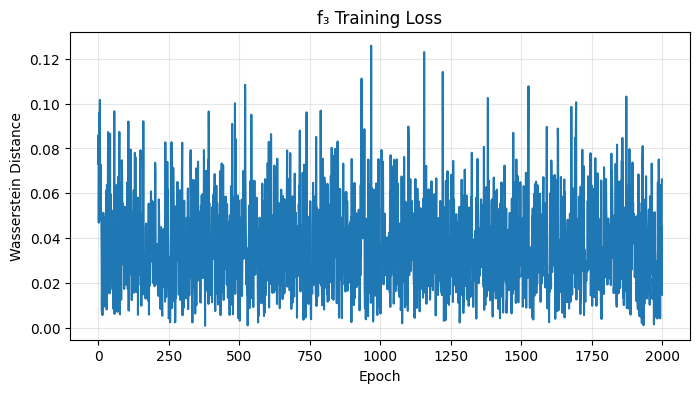


Analyzing the learned mapping...


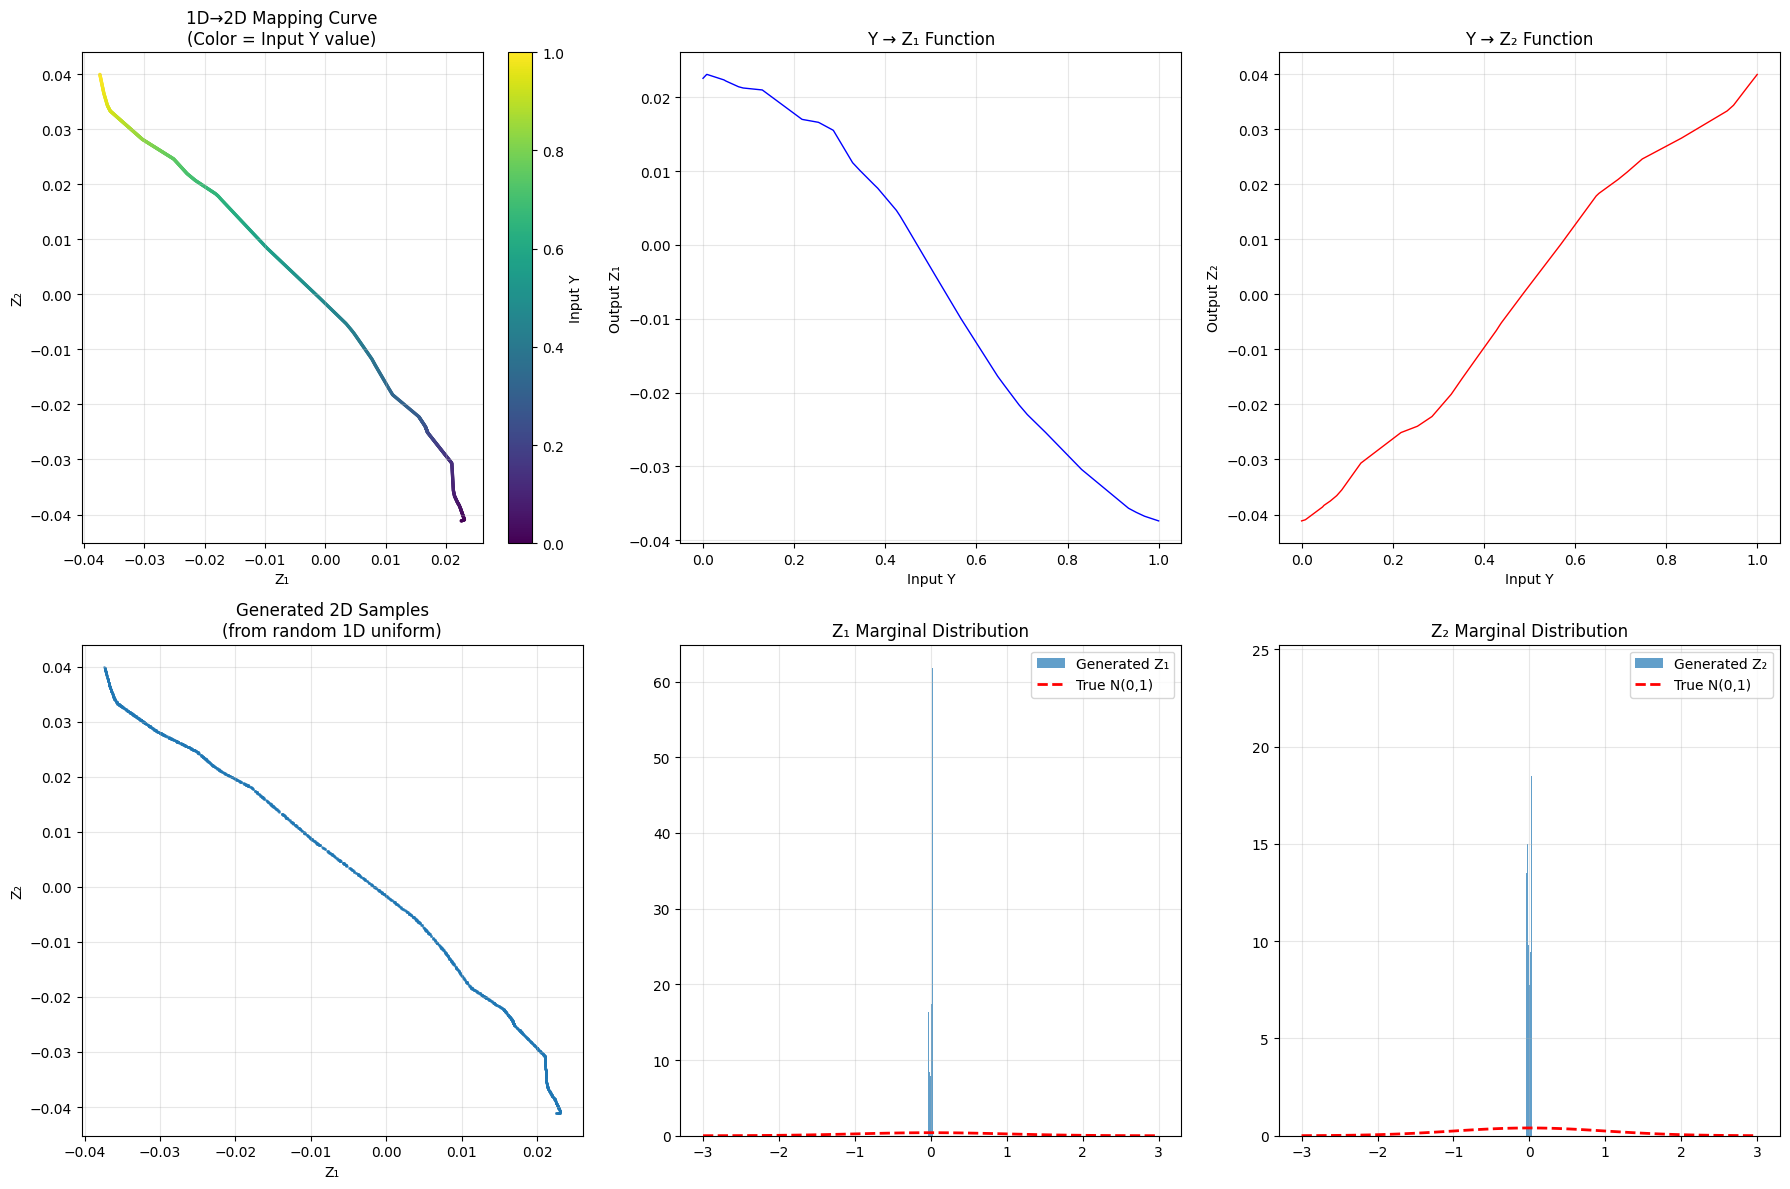


MAPPING ANALYSIS:
--------------------------------------------------
Input range: [0, 1] (1D)
Output range: Z₁ ∈ [-0.037, 0.023]
              Z₂ ∈ [-0.041, 0.040]
Generated mean: (-0.005, 0.000)
Generated std:  (0.021, 0.025)
Target mean: (0.000, 0.000)
Target std:  (1.000, 1.000)

HOW DOES 1D → 2D TRANSFORMATION WORK?

KEY INSIGHTS:

1. SPACE-FILLING CURVE: The network learns a continuous curve in 2D space
   that maps the 1D interval [0,1] to regions that approximate 2D Gaussian

2. NONLINEAR MAPPING: Despite being deterministic, the nonlinear neural 
   network creates complex mappings that can approximate any distribution

3. DISTRIBUTION MATCHING: The curve "fills" 2D space in a way that the 
   density of points matches the target Gaussian distribution

4. LEARNED INVERSE CDF: Effectively learns a 2D generalization of the 
   inverse cumulative distribution function

MATHEMATICAL PRINCIPLE:
- Input: Y ~ U[0,1] (uniform random variable)
- Output: Z = f₃(Y) where Z ~ N(0,I)² appr

In [19]:
# Run the demonstration
if __name__ == "__main__":
    trained_model = demonstrate_1d_to_2d()